In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

## Load data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0")

In [ ]:
transform = transforms.Compose([
  transforms.Resize(255),
  transforms.CenterCrop(255),
  transforms.ToTensor(),
  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_d = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset/hymenoptera_data/train', transform=transform)
val_d = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset/hymenoptera_data/val', transform=transform)
train_l = torch.utils.data.DataLoader(train_d, batch_size=5,shuffle=True, num_workers=2)
val_l = torch.utils.data.DataLoader(val_d, batch_size=5,shuffle=False, num_workers=2)

## Build neural network

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.conv3 = nn.Conv2d(16, 36, 5)
    self.fc1 = nn.Linear(28224, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


net = Net()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [ ]:
i = 0
t_losses = []
for epoch in range(25):
  stotal_loss = 0.0
  net.train()
  for data in train_l:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    t_loss = criterion(outputs, labels)
    t_loss.backward()
    optimizer.step()
    t_losses.append(t_loss.item())
    i += 1

print('Finished Training')

Finished Training


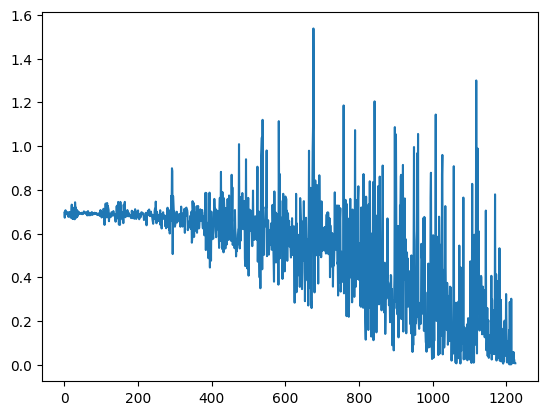

In [ ]:
plt.plot(range(len(t_losses)), t_losses)

## Validation

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in val_l:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

Accuracy: 52 %


## Augmentation

In [ ]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(255),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.2, 0.4, 0, 0.2),
    transforms.RandomGrayscale(0.3)
])

train_d = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset/hymenoptera_data/train', transform=transform)
val_d = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset/hymenoptera_data/val', transform=transform)
train_l = torch.utils.data.DataLoader(train_d, batch_size=4,shuffle=True, num_workers=2)
val_l = torch.utils.data.DataLoader(val_d, batch_size=4,shuffle=False, num_workers=2)

In [ ]:
i = 0
t_losses = []
v_losses = []
for epoch in range(50):
  net.train()
  for data in train_l:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    t_loss = criterion(outputs, labels)
    t_loss.backward()
    optimizer.step()
    t_losses.append(t_loss.item())
    i += 1

print('Finished Training')

Finished Training


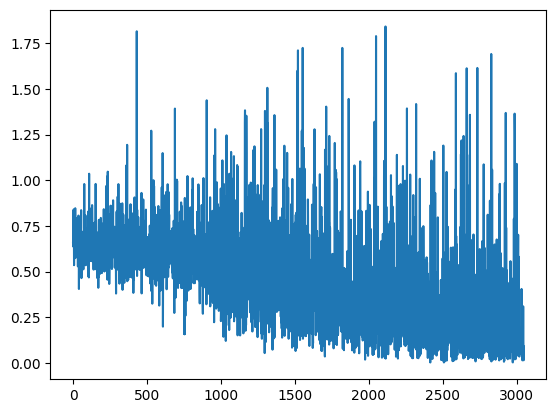

In [ ]:
plt.plot(range(len(t_losses)), t_losses)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in val_l:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

Accuracy: 60 %
